## Урок 4. Uplift-моделирование
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки.
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов).
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями.
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей.
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево.

### 1. Загружу и проанализирую данные

In [1]:
# !pip install catboost
# !pip install causalml
# !pip install scikit-uplift==0.2.0
# !git clone https://github.com/ub8er/causalml.git
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install 

In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

In [2]:
df_clients = pd.read_csv('data.csv')
df_clients.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
len(df_clients)

64000

In [4]:
df_clients.dropna(inplace = True)
len(df_clients)

64000

In [5]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.9+ MB


In [6]:
df_clients.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


### 2. Переименую поля (conversion -> target, offer -> treatment) и приведу поле treatment к бинарному виду

In [7]:
df_clients.rename(columns = {'conversion':'target', 'offer':'treatment'}, inplace = True)
df_clients.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [8]:
df_clients.treatment.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [9]:
df_clients.treatment.replace(to_replace=['Buy One Get One', 'Discount'], value=1, inplace=True)
df_clients.treatment.replace(to_replace=['No Offer'], value=0, inplace=True)
df_clients.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

Поле target - это целевая переменная, а treatment - коммуникация.

### 3. Сделаю feature engineering
Переведу номиальные признаки zip_code и channel в бинарные.

In [10]:
df_clients = pd.concat([df_clients, pd.get_dummies(df_clients['zip_code'], prefix='zip_code')], axis=1)
df_clients = pd.concat([df_clients, pd.get_dummies(df_clients['channel'], prefix='channel')], axis=1)

df_clients.drop(['zip_code', 'channel'], axis=1, inplace=True)

df_clients.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1


In [11]:
cols = df_clients.columns.tolist()
cols

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'treatment',
 'target',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [12]:
df_clients = df_clients[['recency', 'history', 'used_discount', 'used_bogo',
                        'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                        'is_referral',
                        'channel_Multichannel', 'channel_Phone', 'channel_Web',
                        'treatment', 'target'
                       ]]
df_clients.head(3)

,recency,history,used_discount,used_bogo,zip_code_Rural,zip_code_Surburban,zip_code_Urban,is_referral,channel_Multichannel,channel_Phone,channel_Web,treatment,target
0,10,142.44,1,0,0,1,0,0,0,1,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,1,0,0
2,7,180.65,0,1,0,1,0,1,0,0,1,1,0


### 4. Разделю данные на train и test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_clients, 
                                                    df_clients['target'], random_state=0)

### 5. Проведу uplift-моделирование

In [14]:
df_train = X_train
df_features = X_train.copy()

In [15]:
X_train.index

Int64Index([ 1098, 13764, 45116, 15363, 44498, 31429,  7222, 19731, 42133,
            54407,
            ...
            57043, 41993, 32103, 30403, 21243, 45891, 52416, 42613, 43567,
             2732],
           dtype='int64', length=48000)

In [16]:
indices_train = X_train.index
indices_learn, indices_valid = train_test_split(X_train.index, test_size=0.3, random_state=123)

Заведем переменные

In [17]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

cat_features = ['recency']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': [],
}

**Одна модель с признаком коммуникации**

uplift@30%: 0.2061


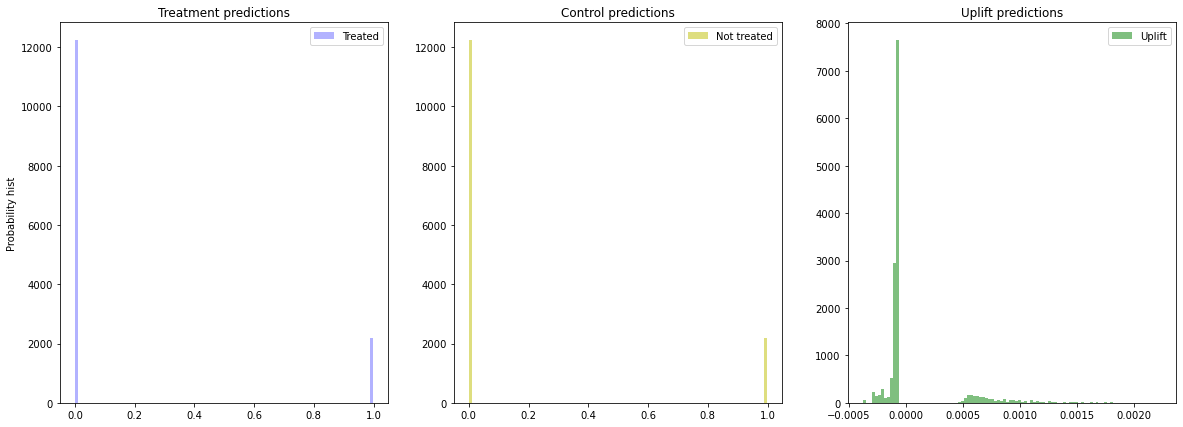

In [18]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_thirty = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score_thirty:.4f}')
sm_score_twenty = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_ten = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score_thirty)
models_results['uplift@20%'].append(sm_score_twenty)
models_results['uplift@10%'].append(sm_score_ten)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [19]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,target,98.262515
1,history,1.178631
2,treatment,0.232240
3,zip_code_Rural,0.228384
4,channel_Web,0.030902
5,zip_code_Urban,0.027628
6,used_bogo,0.015698
7,channel_Phone,0.008424
8,is_referral,0.007260
9,used_discount,0.005680


**Трансформация классов**

In [20]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_thirty = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_score_twenty = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_ten = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_thirty)
models_results['uplift@20%'].append(ct_score_twenty)
models_results['uplift@10%'].append(ct_score_ten)

<ipython-input-20-d7d9571fe099>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


**Две независимые модели**

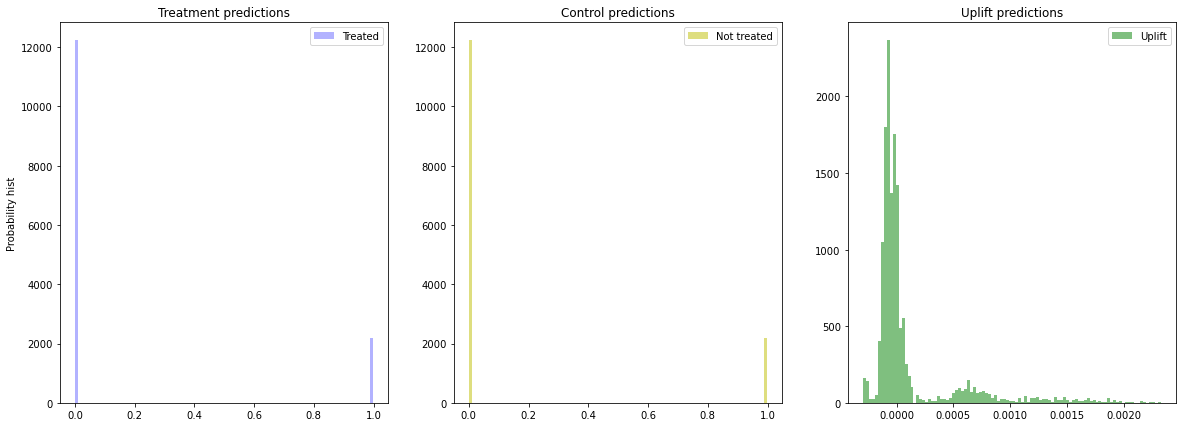

In [21]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_thirty = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
tm_score_twenty = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_ten = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score_thirty)
models_results['uplift@20%'].append(tm_score_twenty)
models_results['uplift@10%'].append(tm_score_ten)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

### 6. Выведу единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [22]:
pd.DataFrame(data=models_results)

,approach,uplift@30%,uplift@20%,uplift@10%
0,SoloModel,0.206114,0.309216,0.0
1,ClassTransformation,0.571675,0.857364,1.0
2,TwoModels,0.206114,0.309216,0.0


### 7. Построю модель UpliftTreeClassifier

In [23]:
X_train_tree = pd.concat([X_train.drop('recency', 1), 
                          pd.get_dummies(X_train['recency'], prefix='recency')], 1)
features = [col for col in X_train_tree]

In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())